# Time Series Analysis and Prediction Using LSTM 

**Problem Description
The task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
**
The dataset is available for free from the kaggle webpage as a CSV download with the filename "international-airline-passengers.csv".


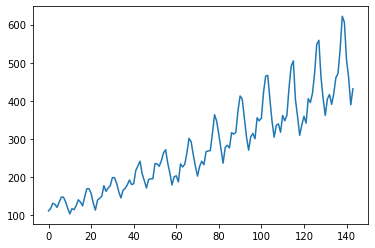

In [83]:
import pandas
import matplotlib.pyplot as plt

# 1st column of csv file is "date" which we don't need. And 3 footer lines can also be skipped.
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

**LSTM Network for Regression**
We can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month's (t) passenger count and the second column containing next month's (t+1) passenger count, to be predicted.

Before we get started, let's first import all of the functions and classes we intend to use. This assumes a working SciPy environment with the Keras deep learning library installed.

In [85]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
# fix random seed for reproducibility
seed = numpy.random.seed(7)

We can also use the code from the previous section to load the dataset as a Pandas dataframe. We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [9]:
# load the dataset
filename = 'international-airline-passengers.csv'
skipfooter = 2
dataframe = pandas.read_csv(filename, usecols=[1], engine='python', skipfooter=skipfooter)
dataset = dataframe.values
dataset = dataset.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [11]:
# normalize the dataset
data_range = (-1, 1)
scaler = MinMaxScaler(feature_range=data_range)        # scaler can also de-normalize the dataset by scaler.inverse_transform(), useful for actual prediction
dataset_scaled = scaler.fit_transform(dataset)
#dataset_scaled = numpy.array(dataset_scaled)

In [13]:
print(dataset_scaled.shape)
print(len(dataset_scaled))
print(dataset_scaled[0:10])

(144, 1)
144
[[-0.9691119 ]
 [-0.94594586]
 [-0.89189184]
 [-0.9034748 ]
 [-0.9343629 ]
 [-0.8803088 ]
 [-0.8301158 ]
 [-0.8301158 ]
 [-0.8764478 ]
 [-0.9420849 ]]


After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [15]:
# split into train and test sets
train_size = int(len(dataset_scaled) * 0.67)
test_size = len(dataset_scaled) - train_size
train, test = dataset_scaled[0:train_size,:], dataset_scaled[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    i_range = len(data) - look_back - 1
    print(i_range)
    for i in range(0, i_range):
        dataX.append(data[i:(i+look_back)])    # index can move down to len(dataset)-1
        dataY.append(data[i + look_back])      # Y is the item that skips look_back number of items
    
    return numpy.array(dataX), numpy.array(dataY)

In [19]:
# try it
look_back = 4
dataX, dataY = create_dataset(dataset_scaled, look_back=look_back)

139


In [21]:
print("X shape:", dataX.shape)
print("Y shape:", dataY.shape)
   
print("Xt-3     Xt-2      Xt-1      Xt        Y")
print("---------------------------------------------")
for i in range(len(dataX)): 
    print('%.2f   %.2f    %.2f    %.2f    %.2f' % (dataX[i][0][0], dataX[i][1][0], dataX[i][2][0], dataX[i][3][0], dataY[i][0]))

X shape: (139, 4, 1)
Y shape: (139, 1)
Xt-3     Xt-2      Xt-1      Xt        Y
---------------------------------------------
-0.97   -0.95    -0.89    -0.90    -0.93
-0.95   -0.89    -0.90    -0.93    -0.88
-0.89   -0.90    -0.93    -0.88    -0.83
-0.90   -0.93    -0.88    -0.83    -0.83
-0.93   -0.88    -0.83    -0.83    -0.88
-0.88   -0.83    -0.83    -0.88    -0.94
-0.83   -0.83    -0.88    -0.94    -1.00
-0.83   -0.88    -0.94    -1.00    -0.95
-0.88   -0.94    -1.00    -0.95    -0.96
-0.94   -1.00    -0.95    -0.96    -0.92
-1.00   -0.95    -0.96    -0.92    -0.86
-0.95   -0.96    -0.92    -0.86    -0.88
-0.96   -0.92    -0.86    -0.88    -0.92
-0.92   -0.86    -0.88    -0.92    -0.83
-0.86   -0.88    -0.92    -0.83    -0.75
-0.88   -0.92    -0.83    -0.75    -0.75
-0.92   -0.83    -0.75    -0.75    -0.79
-0.83   -0.75    -0.75    -0.79    -0.89
-0.75   -0.75    -0.79    -0.89    -0.96
-0.75   -0.79    -0.89    -0.96    -0.86
-0.79   -0.89    -0.96    -0.86    -0.84
-0.89   -0.96

In [23]:
# Reshape to (samples, timestep, features)
dataX = numpy.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))

print("X shape:", dataX.shape)


X shape: (139, 1, 4)


Let's use this function to prepare the train and test datasets for modeling.

In [25]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)      # trainX is input, trainY is expected output
testX, testY = create_dataset(test, look_back)

94
46


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of 3D: [samples, time steps, features], or in other words, 3D tensor with shape (batch_size, timesteps, input_dim), or optionally, 2D tensors with shape (batch_size, output_dim).

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [27]:
# reshape input to be [samples, time steps, features]
print("Original trainX shape:", trainX.shape)
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))     # timestep = 1, input_dim = trainX.shape[1]
testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))
print("New trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("trainY example:", trainY[0])

Original trainX shape: (94, 1, 1)
New trainX shape: (94, 1, 1)
trainY shape: (94, 1)
trainY example: [-0.94594586]


We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

                output layer ------>         Y
                                             |
                                           Dense
                                         / |   | \
                                        /  |   |  \
                Hidden layer (LSTM)    L1->L2->L3->L4
                                       |
                Input layer  ----->    X

In [29]:
# create and fit the LSTM network
from keras.layers import Dropout

batch_size = 1
timesteps = trainX.shape[1]
input_dim = trainX.shape[2]

model = Sequential()
#model.add(LSTM(8, input_shape=(1, look_back)))    # 4 or 8 is the number of LSTM units or dimensions of output of LSTM layer, can be any integer. input_shape must show up in the first layer
model.add(LSTM(4, batch_input_shape=(batch_size, timesteps, input_dim)))
model.add(Dense(10))    # not necessary, but just want to try it
#model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)   # it turns out that epochs = 15 is enough, 100 is not necessary

Epoch 1/50
94/94 - 2s - loss: 0.1744 - 2s/epoch - 16ms/step
Epoch 2/50
94/94 - 0s - loss: 0.0465 - 153ms/epoch - 2ms/step
Epoch 3/50
94/94 - 0s - loss: 0.0363 - 126ms/epoch - 1ms/step
Epoch 4/50
94/94 - 0s - loss: 0.0285 - 130ms/epoch - 1ms/step
Epoch 5/50
94/94 - 0s - loss: 0.0206 - 124ms/epoch - 1ms/step
Epoch 6/50
94/94 - 0s - loss: 0.0145 - 108ms/epoch - 1ms/step
Epoch 7/50
94/94 - 0s - loss: 0.0111 - 115ms/epoch - 1ms/step
Epoch 8/50
94/94 - 0s - loss: 0.0093 - 107ms/epoch - 1ms/step
Epoch 9/50
94/94 - 0s - loss: 0.0087 - 110ms/epoch - 1ms/step
Epoch 10/50
94/94 - 0s - loss: 0.0083 - 108ms/epoch - 1ms/step
Epoch 11/50
94/94 - 0s - loss: 0.0081 - 111ms/epoch - 1ms/step
Epoch 12/50
94/94 - 0s - loss: 0.0082 - 109ms/epoch - 1ms/step
Epoch 13/50
94/94 - 0s - loss: 0.0082 - 112ms/epoch - 1ms/step
Epoch 14/50
94/94 - 0s - loss: 0.0089 - 113ms/epoch - 1ms/step
Epoch 15/50
94/94 - 0s - loss: 0.0083 - 108ms/epoch - 1ms/step
Epoch 16/50
94/94 - 0s - loss: 0.0084 - 106ms/epoch - 1ms/step
Epo

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [31]:
# make predictions
trainPredict = model.predict(trainX, batch_size)
testPredict = model.predict(testX, batch_size)      

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)               # trainY is of shape (samples, features) while trainX is of (samples, timesteps, features) )
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

print("trainY shape:", trainY.shape)
print("trainPredict shape:", trainPredict.shape)
print("testY shape:", testY.shape)
print("testPredict shape:", testPredict.shape)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

46/46 [==============================] - 0s 914us/step
trainY shape: (94, 1)
trainPredict shape: (94, 1)
testY shape: (46, 1)
testPredict shape: (46, 1)
Train Score: 22.91 RMSE
Test Score: 66.94 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset (because the output Y is 1 timestep shift from input X). Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

In [35]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset,dtype=float)
trainPredictPlot[:, :] = numpy.nan
#print(trainPredictPlot[0])
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset,dtype=float)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


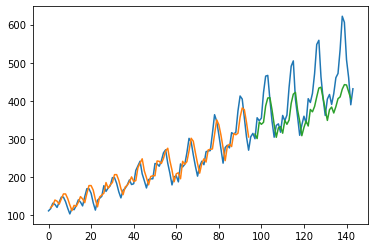

In [37]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_scaled))
#plt.plot(dataset_scaled)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# LSTM for Regression Using the Window Method
We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

This is called a window, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.

When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.

The create_dataset() function we created in the previous section allows us to create this formulation of the time series problem by increasing the look_back argument from 1 to 3.

In [39]:
# reshape into X=t-2, t-1. t, and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)      # trainX is input, trainY is expected output
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
print("Original trainX shape:", trainX.shape)
print("Original testX shape:", testX.shape)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))    # input_dim = trainX.shape[1] = 4
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("New trainX shape:", trainX.shape)
print("New testX shape:", testX.shape)
print("trainY shape:", trainY.shape)
print("trainY example:", trainY[0])

91
43
Original trainX shape: (91, 4, 1)
Original testX shape: (43, 4, 1)
New trainX shape: (91, 1, 4)
New testX shape: (43, 1, 4)
trainY shape: (91, 1)
trainY example: [-0.9343629]


In [41]:
batch_size = 1
timesteps = trainX.shape[1]
input_dim = trainX.shape[2]

model = Sequential()

# model.add(LSTM(8, input_shape=(1, look_back)))    # 4 or 8 is the number of LSTM units or dimensions of output of LSTM layer, can be any integer. input_shape must show up in the first layer
model.add(LSTM(8, batch_input_shape=(batch_size, timesteps, input_dim)))
model.add(Dense(10))    # not necessary, but just want to try it
#model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)   # it turns out that epochs = 15 is enough, 100 is not necessary

Epoch 1/50
91/91 - 1s - loss: 0.0966 - 1s/epoch - 15ms/step
Epoch 2/50
91/91 - 0s - loss: 0.0328 - 108ms/epoch - 1ms/step
Epoch 3/50
91/91 - 0s - loss: 0.0270 - 109ms/epoch - 1ms/step
Epoch 4/50
91/91 - 0s - loss: 0.0240 - 108ms/epoch - 1ms/step
Epoch 5/50
91/91 - 0s - loss: 0.0208 - 107ms/epoch - 1ms/step
Epoch 6/50
91/91 - 0s - loss: 0.0203 - 110ms/epoch - 1ms/step
Epoch 7/50
91/91 - 0s - loss: 0.0189 - 107ms/epoch - 1ms/step
Epoch 8/50
91/91 - 0s - loss: 0.0166 - 108ms/epoch - 1ms/step
Epoch 9/50
91/91 - 0s - loss: 0.0162 - 107ms/epoch - 1ms/step
Epoch 10/50
91/91 - 0s - loss: 0.0149 - 107ms/epoch - 1ms/step
Epoch 11/50
91/91 - 0s - loss: 0.0139 - 110ms/epoch - 1ms/step
Epoch 12/50
91/91 - 0s - loss: 0.0128 - 110ms/epoch - 1ms/step
Epoch 13/50
91/91 - 0s - loss: 0.0124 - 108ms/epoch - 1ms/step
Epoch 14/50
91/91 - 0s - loss: 0.0116 - 108ms/epoch - 1ms/step
Epoch 15/50
91/91 - 0s - loss: 0.0104 - 113ms/epoch - 1ms/step
Epoch 16/50
91/91 - 0s - loss: 0.0097 - 114ms/epoch - 1ms/step
Epo

In [43]:
x = testX[0, :, :]   # one row of testX
timesteps, input_dim = x.shape
print("Shape of one row of testX:", x.shape)
x = x.reshape(batch_size, timesteps, input_dim)
#testX = testX.reshape(samples,timesteps, input_dim )
testPredict = model.predict(x, batch_size=batch_size)
print("testPredict shape:", testPredict.shape)
print("testPredict:", testPredict)
print("testPredict:", testPredict[0, 0])

Shape of one row of testX: (1, 4)
1/1 [==============================] - 0s 284ms/step
testPredict shape: (1, 1)
testPredict: [[-0.13792753]]
testPredict: -0.13792753


In [45]:
# make predictions
#trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)      
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)      

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)               # trainY is of shape (samples, features) while trainX is of (samples, timesteps, features) )
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

print("trainY shape:", trainY.shape)
print("trainPredict shape:", trainPredict.shape)
print("testY shape:", testY.shape)
print("testPredict shape:", testPredict.shape)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

43/43 [==============================] - 0s 953us/step
trainY shape: (91, 1)
trainPredict shape: (91, 1)
testY shape: (43, 1)
testPredict shape: (43, 1)
Train Score: 25.50 RMSE
Test Score: 72.68 RMSE


In [49]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset,dtype=float)
trainPredictPlot[:, :] = numpy.nan
#print(trainPredictPlot[0])
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset,dtype=float)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


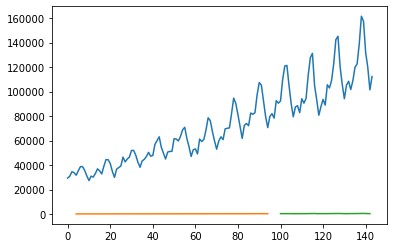

In [51]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [53]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 8)                    416       
                                                                 
 dense_2 (Dense)             (1, 10)                   90        
                                                                 
 dense_3 (Dense)             (1, 1)                    11        
                                                                 
Total params: 517 (2.02 KB)
Trainable params: 517 (2.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [55]:
# reshape X into 4 timesteps for one feature vector (Xt-3, Xt-2, Xt-1, Xt), with expected output Y at t
look_back = 4
timesteps = 4
trainX, trainY = create_dataset(train, look_back)      # trainX is input, trainY is expected output (label)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
print("Original trainX shape:", trainX.shape)
print("Original testX shape:", testX.shape)
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))   # samples = trainX.shape[0], timesteps = trainX.shape[1], features = 1
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print("New trainX shape:", trainX.shape)
print("New testX shape:", testX.shape)
print("trainY shape:", trainY.shape)
print("trainY example:", trainY[0])

91
43
Original trainX shape: (91, 4, 1)
Original testX shape: (43, 4, 1)
New trainX shape: (91, 4, 1)
New testX shape: (43, 4, 1)
trainY shape: (91, 1)
trainY example: [-0.9343629]


In [57]:
model = Sequential()
batch_size = 1
input_dim = trainX.shape[2]
timesteps = trainX.shape[1]
# my_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=seed)
#model.add(LSTM(8, input_shape=(look_back, 1)))    # 4 or 8 is the number of LSTM units or dimensions of output of LSTM layer, can be any integer. input_shape must show up in the first layer
model.add(LSTM(8, batch_input_shape=(batch_size, timesteps, input_dim)))  # input_dim = 1
model.add(Dense(10))    # may not be necessary, but just want to try it
#model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=batch_size, verbose=2)   # it turns out that epochs = 15 is enough, 100 is not necessary

Epoch 1/50
91/91 - 1s - loss: 0.0592 - 1s/epoch - 16ms/step
Epoch 2/50
91/91 - 0s - loss: 0.0220 - 134ms/epoch - 1ms/step
Epoch 3/50
91/91 - 0s - loss: 0.0188 - 131ms/epoch - 1ms/step
Epoch 4/50
91/91 - 0s - loss: 0.0170 - 132ms/epoch - 1ms/step
Epoch 5/50
91/91 - 0s - loss: 0.0166 - 130ms/epoch - 1ms/step
Epoch 6/50
91/91 - 0s - loss: 0.0166 - 129ms/epoch - 1ms/step
Epoch 7/50
91/91 - 0s - loss: 0.0153 - 139ms/epoch - 2ms/step
Epoch 8/50
91/91 - 0s - loss: 0.0151 - 132ms/epoch - 1ms/step
Epoch 9/50
91/91 - 0s - loss: 0.0152 - 139ms/epoch - 2ms/step
Epoch 10/50
91/91 - 0s - loss: 0.0145 - 147ms/epoch - 2ms/step
Epoch 11/50
91/91 - 0s - loss: 0.0146 - 155ms/epoch - 2ms/step
Epoch 12/50
91/91 - 0s - loss: 0.0146 - 168ms/epoch - 2ms/step
Epoch 13/50
91/91 - 0s - loss: 0.0148 - 137ms/epoch - 2ms/step
Epoch 14/50
91/91 - 0s - loss: 0.0142 - 130ms/epoch - 1ms/step
Epoch 15/50
91/91 - 0s - loss: 0.0133 - 130ms/epoch - 1ms/step
Epoch 16/50
91/91 - 0s - loss: 0.0140 - 131ms/epoch - 1ms/step
Epo

In [59]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)   # can't omit batch_size which must be the same as that in model.fit()
testPredict = model.predict(testX, batch_size=batch_size)      

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)               # trainY is of shape (samples, features) while trainX is of (samples, timesteps, features) )
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

print("trainY shape:", trainY.shape)
print("trainPredict shape:", trainPredict.shape)
print("testY shape:", testY.shape)
print("testPredict shape:", testPredict.shape)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

43/43 [==============================] - 0s 981us/step
trainY shape: (91, 1)
trainPredict shape: (91, 1)
testY shape: (43, 1)
testPredict shape: (43, 1)
Train Score: 22.33 RMSE
Test Score: 56.07 RMSE


In [61]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset,dtype=float)
trainPredictPlot[:, :] = numpy.nan
#print(trainPredictPlot[0])
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset,dtype=float)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

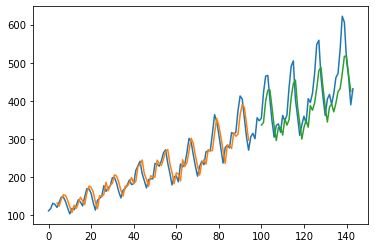

In [63]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# LSTM for Regression with Time Steps
You may have noticed that the data preparation for the LSTM network includes time steps.

Some sequence problems may have a varied number of time steps per sample. For example, you may have measurements of a physical machine leading up to a point of failure or a point of surge. Each incident would be a sample the observations that lead up to the event would be the time steps, and the variables observed would be the features.

Time steps provide another way to phrase our time series problem. Like above in the window example, we can take prior time steps in our time series as inputs to predict the output at the next time step.

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.

We can do this using the same data representation as in the previous window-based example, except when we reshape the data, we set the columns to be the time steps dimension (timesteps is not 1 anymore) and change the features dimension back to 1. Note that input_shape of the model is changed as well.

In [65]:
# reshape into 4 timesteps for one feature (Xt-3, Xt-2, Xt-1, Xt), with expected output Y at t
look_back = 4
trainX, trainY = create_dataset(train, look_back)      # trainX is input, trainY is expected output
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
print("Original trainX shape:", trainX.shape)
print("Original testX shape:", testX.shape)
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))   # timesteps = trainX.shape[1], input_dim = 1
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print("New trainX shape:", trainX.shape)
print("New testX shape:", testX.shape)
print("trainY shape:", trainY.shape)
print("trainY example:", trainY[0])

91
43
Original trainX shape: (91, 4, 1)
Original testX shape: (43, 4, 1)
New trainX shape: (91, 4, 1)
New testX shape: (43, 4, 1)
trainY shape: (91, 1)
trainY example: [-0.9343629]


In [67]:
batch_size = 1
model = Sequential()

# model.add(LSTM(8, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(8, batch_input_shape=(batch_size, look_back, 1), stateful=True))

model.add(Dense(10)) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

for i in range(50):    # corresponding to epochs = 50
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=True)
	model.reset_states()

91/91 - 3s - loss: 0.1237 - 3s/epoch - 38ms/step
91/91 - 0s - loss: 0.0607 - 316ms/epoch - 3ms/step
91/91 - 0s - loss: 0.0610 - 292ms/epoch - 3ms/step
91/91 - 0s - loss: 0.0500 - 378ms/epoch - 4ms/step
91/91 - 0s - loss: 0.0399 - 246ms/epoch - 3ms/step
91/91 - 0s - loss: 0.0353 - 256ms/epoch - 3ms/step
91/91 - 0s - loss: 0.0341 - 287ms/epoch - 3ms/step
91/91 - 0s - loss: 0.0292 - 226ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0243 - 197ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0201 - 211ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0179 - 198ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0193 - 192ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0172 - 203ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0179 - 210ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0167 - 193ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0169 - 190ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0170 - 191ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0154 - 191ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0160 - 213ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0150 - 242ms

In [69]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)

model.reset_states()  # this sentence should not be neglected.
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)               # trainY is of shape (samples, features) while trainX is of (samples, timesteps, features) )
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

print("trainY shape:", trainY.shape)
print("trainPredict shape:", trainPredict.shape)
print("testY shape:", testY.shape)
print("testPredict shape:", testPredict.shape)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

43/43 [==============================] - 0s 2ms/step
trainY shape: (91, 1)
trainPredict shape: (91, 1)
testY shape: (43, 1)
testPredict shape: (43, 1)
Train Score: 24.73 RMSE
Test Score: 89.54 RMSE


In [71]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset,dtype=float)
trainPredictPlot[:, :] = numpy.nan
#print(trainPredictPlot[0])
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset,dtype=float)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

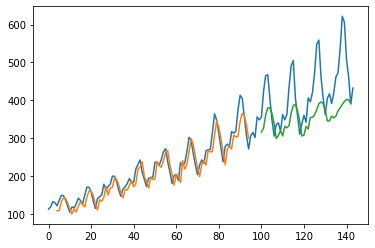

In [73]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# LSTM with Memory Between Batches
The LSTM network has memory, which is capable of remembering across long sequences.

Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate().

We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer stateful. This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions.

Jiyang's note: "state" is what one unit sends to the next units or itself (i.e. memory), which is different from weights and outputs.

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states().

*Jiyang's note: I set shuffle=True in model.fit and unexpectedly got better test accuracy vs. shuffle=False (43 vs. 72) as I thought shuffle or not doesn't matte when batch_size = 1. *

In [75]:
# reshape into 4 timesteps for one feature (Xt-3, Xt-2, Xt-1, Xt), with expected output Y at t
look_back = 4
trainX, trainY = create_dataset(train, look_back)      # trainX is input, trainY is expected output
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
print("Original trainX shape:", trainX.shape)
print("Original testX shape:", testX.shape)
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))   # timesteps = trainX.shape[1], input_dim = 1
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print("New trainX shape:", trainX.shape)
print("New testX shape:", testX.shape)
print("trainY shape:", trainY.shape)
print("trainY example:", trainY[0])

91
43
Original trainX shape: (91, 4, 1)
Original testX shape: (43, 4, 1)
New trainX shape: (91, 4, 1)
New testX shape: (43, 4, 1)
trainY shape: (91, 1)
trainY example: [-0.9343629]


In [77]:
batch_size = 1
timesteps = trainX.shape[1]
input_dim = trainX.shape[2]

model = Sequential()

model.add(LSTM(8, batch_input_shape=(batch_size, timesteps, input_dim), stateful=True))
model.add(Dense(10)) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(50):    # corresponding to epochs = 50
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

91/91 - 2s - loss: 0.0616 - 2s/epoch - 17ms/step
91/91 - 0s - loss: 0.0273 - 158ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0241 - 151ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0219 - 131ms/epoch - 1ms/step
91/91 - 0s - loss: 0.0204 - 136ms/epoch - 1ms/step
91/91 - 0s - loss: 0.0193 - 132ms/epoch - 1ms/step
91/91 - 0s - loss: 0.0186 - 132ms/epoch - 1ms/step
91/91 - 0s - loss: 0.0180 - 133ms/epoch - 1ms/step
91/91 - 0s - loss: 0.0174 - 143ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0170 - 156ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0166 - 135ms/epoch - 1ms/step
91/91 - 0s - loss: 0.0163 - 141ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0159 - 163ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0156 - 138ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0154 - 131ms/epoch - 1ms/step
91/91 - 0s - loss: 0.0151 - 140ms/epoch - 2ms/step
91/91 - 0s - loss: 0.0149 - 135ms/epoch - 1ms/step
91/91 - 0s - loss: 0.0146 - 134ms/epoch - 1ms/step
91/91 - 0s - loss: 0.0144 - 132ms/epoch - 1ms/step
91/91 - 0s - loss: 0.0141 - 149ms

In [79]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()  # this sentence should not be neglected.
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_new = scaler.inverse_transform(trainY)               # trainY is of shape (samples, features) while trainX is of (samples, timesteps, features) )
testPredict = scaler.inverse_transform(testPredict)
testY_new = scaler.inverse_transform(testY)

print("trainY shape:", trainY_new.shape)
print("trainPredict shape:", trainPredict.shape)
print("testY shape:", testY_new.shape)
print("testPredict shape:", testPredict.shape)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_new, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_new, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

43/43 [==============================] - 0s 2ms/step
trainY shape: (91, 1)
trainPredict shape: (91, 1)
testY shape: (43, 1)
testPredict shape: (43, 1)
Train Score: 30.82 RMSE
Test Score: 54.89 RMSE


In [81]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
#print(trainPredictPlot[0])
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

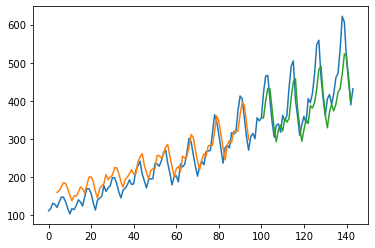

In [83]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Shampoo Sales Forecast

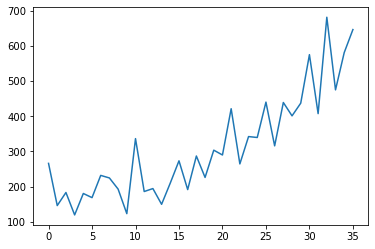

In [85]:
import pandas
import matplotlib.pyplot as plt

# 1st column of csv file is "date" which we don't need. And 3 footer lines can also be skipped.
dataset = pandas.read_csv('sales-of-shampoo-over-a-three-ye.csv', usecols=[1], engine='python',skipfooter=1)

plt.plot(dataset)
plt.show()

In [87]:
print(dataset.head())

   Sales of shampoo over a three year period
0                                      266.0
1                                      145.9
2                                      183.1
3                                      119.3
4                                      180.3


In [89]:
# load the dataset
dataframe = pandas.read_csv('sales-of-shampoo-over-a-three-ye.csv', usecols=[1], engine='python', skipfooter=2)
dataset = dataframe.values
dataset = dataset.astype('float32')
print(dataset)

[[266. ]
 [145.9]
 [183.1]
 [119.3]
 [180.3]
 [168.5]
 [231.8]
 [224.5]
 [192.8]
 [122.9]
 [336.5]
 [185.9]
 [194.3]
 [149.5]
 [210.1]
 [273.3]
 [191.4]
 [287. ]
 [226. ]
 [303.6]
 [289.9]
 [421.6]
 [264.5]
 [342.3]
 [339.7]
 [440.4]
 [315.9]
 [439.3]
 [401.3]
 [437.4]
 [575.5]
 [407.6]
 [682. ]
 [475.3]
 [581.3]
 [646.9]]


In [91]:
# split data into train and test
train, test = dataset[0:-12], dataset[-12:]     # the last 12 items are for test, the rest for training

# Persistence Model Forecast - Baseline
A good baseline forecast for a time series with a linear increasing trend is a persistence forecast.

The persistence forecast is where the observation from the prior time step (t-1) is used to predict the observation at the current time step (t).

We can implement this by taking the last observation from the training data and history accumulated by walk-forward validation and using that to predict the current time step.

series shape: (36,)
Month
2011-01-01    266.0
2011-02-01    145.9
2011-03-01    183.1
2011-04-01    119.3
2011-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


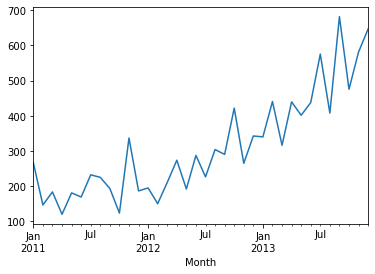

In [93]:
import warnings
warnings.filterwarnings("ignore")

from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# load dataset

def parser(x):
	return datetime.strptime('201'+x, '%Y-%m')   # add year to months, and using format yyyy-mm

series = read_csv('sales-of-shampoo-over-a-three-ye.csv', engine='python', delimiter = ',', index_col=0, header=0, parse_dates=[0], skipfooter=2, squeeze=True, skip_blank_lines=True, date_parser=parser)
# skipfooter = 2 must be added so that the last two rows (an empty row and a footer row) will not be converted to 201y-mm, which also requires engine='python'
print("series shape:", series.shape)
print(series.head())

# line plot
series.plot()
pyplot.show()


In [95]:
data_values = series.values
print("data values shape:", data_values.shape)
print(data_values[0:5])

data values shape: (36,)
[266.  145.9 183.1 119.3 180.3]


RMSE: 136.761


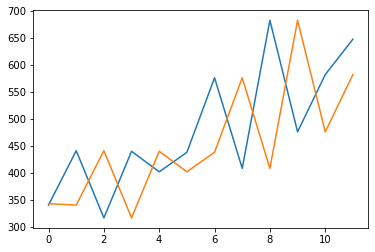

In [97]:
# split data into train and test
X = series.values   # X is still a column vector with 36 rows
#X = dataset
train, test = X[0:-12], X[-12:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])

    # report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

# LSTM Data Preparation
Before we can fit an LSTM model to the dataset, we must transform the data.

This section is broken down into three steps:

Transform the time series into a supervised learning problem
Transform the time series data so that it is stationary.
Transform the observations to have a specific scale.
Transform Time Series to Supervised Learning
The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.

We can then concatenate these two series together to create a DataFrame ready for supervised learning. The pushed-down series will have a new position at the top with no value. A NaN (not a number) value will be used in this position. We will replace these NaN values with 0 values, which the LSTM model will have to learn as the start of the series or have no data here, such as a month with zero sales on this dataset has not been observed.

The code below defines a helper function to do this called timeseries_to_supervised(). It takes a NumPy array of the raw time series data and a lag or number of shifted series to create and use as inputs.

In [99]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat

def timeseries_to_supervised(data, lag=1):
    """Frame a sequence data into a supervised learning problem, i.e., time sequence -> (X, y)"""
    df = DataFrame(data)               # DataFrame is a pandas class
    columns = [df.shift(i) for i in range(1, lag+1)]   # shift() pushed dataframe or a column vector downwards by i spaces
    columns.append(df)      # append the original as the output y onto the last column
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)   # turn NaN to 0
    return df

In [101]:
X = series.values
lags = 4
supervised = timeseries_to_supervised(X, lag = lags)
print(supervised.head())

       0      0      0      0      0
0    0.0    0.0    0.0    0.0  266.0
1  266.0    0.0    0.0    0.0  145.9
2  145.9  266.0    0.0    0.0  183.1
3  183.1  145.9  266.0    0.0  119.3
4  119.3  183.1  145.9  266.0  180.3


In [103]:
import numpy as np
dataset = supervised.values     # must use values because supervised is still a dataframe but LSTM requires 3D array as input
print("Original row:\n", dataset[0:5])

X = dataset[0:5]
print("\nExclude last row, X:\n", X[0:-1])
X = X[0:-1]
print("\nShape of X:", X.shape)

X, y = X[:,0:-1], X[:, -1]
rows, cols = X.shape
X = X.reshape(rows, 1, cols)   # [samples, timestep, features]
print("\nX reshaped to 3D:\n",X)

X = X.reshape(rows, cols, 1)   # [samples, timestep, features]
print("\nX reshaped to 3D:\n",X)

print("\n y in 3D:\n", y)

Original row:
 [[  0.    0.    0.    0.  266. ]
 [266.    0.    0.    0.  145.9]
 [145.9 266.    0.    0.  183.1]
 [183.1 145.9 266.    0.  119.3]
 [119.3 183.1 145.9 266.  180.3]]

Exclude last row, X:
 [[  0.    0.    0.    0.  266. ]
 [266.    0.    0.    0.  145.9]
 [145.9 266.    0.    0.  183.1]
 [183.1 145.9 266.    0.  119.3]]

Shape of X: (4, 5)

X reshaped to 3D:
 [[[  0.    0.    0.    0. ]]

 [[266.    0.    0.    0. ]]

 [[145.9 266.    0.    0. ]]

 [[183.1 145.9 266.    0. ]]]

X reshaped to 3D:
 [[[  0. ]
  [  0. ]
  [  0. ]
  [  0. ]]

 [[266. ]
  [  0. ]
  [  0. ]
  [  0. ]]

 [[145.9]
  [266. ]
  [  0. ]
  [  0. ]]

 [[183.1]
  [145.9]
  [266. ]
  [  0. ]]]

 y in 3D:
 [266.  145.9 183.1 119.3]


**Transform Time Series to Stationary**
The Shampoo Sales dataset is not stationary.

This means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.

Jiyang's comment: is the trend what we'd like the model to capture?

Stationary data is easier to model and will very likely result in more skillful forecasts.

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

We can achieve this automatically using the diff() function in pandas. Alternatively, we can get finer grained control and write our own function to do this, which is preferred for its flexibility in this case.

Below is a function called difference() that calculates a differenced series. Note that the first observation in the series is skipped as there is no prior observation with which to calculate a differenced value.

In [105]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    
    # pandas.Series() turns a list like [-120.1, 37.2, ...] to a time series
    return Series(diff)

We also need to invert this process in order to take forecasts made on the differenced series back into their original scale, by function inverse_difference(), in which history is the data series used to get diff. Our model predicts diff that is to be converted to original scale by diff + history

In [107]:
# invert differenced value
def inverse_difference(history, diff, interval=1):
    return diff + history[-interval]

We can test out these functions by differencing the whole series, then returning it to the original scale, as follows:

In [109]:
from pandas import read_csv
from pandas import datetime
from pandas import Series

differenced = difference(series, interval=1)
print("differenced:")
print(differenced.head())

# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)
inverted = Series(inverted)
print("\n")
print("Inverted back:")
print(inverted.head())

differenced:
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64


Inverted back:
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


In [115]:
def diff(dataset, interval=1):
    """My implementation of diff() function, avoiding using "for" loop. """
    history = dataset[0:-interval]
    new_output = dataset[interval:,]
#    print("history")
#    print(history.head())
#    print("\nnew_output")
#    print(new_output.head())
    return new_output - list(history)

In [117]:
# invert differenced value
def inverse_diff(original, diff, interval=1):
    history = original[-interval]
#    print("History")
#    print(history.head())
    return diff + history

In [119]:
differenced = diff(series, 1)
print(differenced[0:5])

Month
2011-02-01   -120.1
2011-03-01     37.2
2011-04-01    -63.8
2011-05-01     61.0
2011-06-01    -11.8
Name: Sales of shampoo over a three year period, dtype: float64


In [121]:
inverted = inverse_diff(series, differenced, 1)

In [123]:
print("series:")
print(series.head())
print("\nDiff:")
print(differenced.head())
print("\nInverted back:")

print(inverted.head())

series:
Month
2011-01-01    266.0
2011-02-01    145.9
2011-03-01    183.1
2011-04-01    119.3
2011-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64

Diff:
Month
2011-02-01   -120.1
2011-03-01     37.2
2011-04-01    -63.8
2011-05-01     61.0
2011-06-01    -11.8
Name: Sales of shampoo over a three year period, dtype: float64

Inverted back:
Month
2011-02-01    526.8
2011-03-01    684.1
2011-04-01    583.1
2011-05-01    707.9
2011-06-01    635.1
Name: Sales of shampoo over a three year period, dtype: float64


In [125]:
def dataset_split(dataset, train_ratio):
    """ Split dataset into train and test set by ratio of train_ratio (e.g., 0.7 for 70%). """
    train_size = int(len(dataset) * train_ratio)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    
    return train, test

def data_scale(dataset, feature_range=(0,1)):
    """Normalize the dataset to the range of feature_range (e.g., [-1, 1]).
       Scaler can also de-normalize the dataset by scaler.inverse_transform(), useful for actual prediction.
    """
    scaler = MinMaxScaler(feature_range)
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

def data_inverse_scale(scaler, dataset):
    data_array = numpy.array([dataset])
    # print("data_array shape:", data_array.shape)
    data_array = data_array.reshape(1, len(data_array))
    return scaler.inverse_transform(data_array)


In [127]:
def fit_lstm(units, trainset, model_style='window', with_memory=False, epochs=50):
    X, y = trainset[:, 0:-1], trainset[:, -1]

    samples = X.shape[0]

    if model_style == 'window':
        timesteps = 1
        input_dim = X.shape[1]
    elif model_style == 'timestep':
        timesteps = X.shape[1]
        input_dim = 1

    X = X.reshape(samples, timesteps, input_dim)

    batch_size = 1
    timesteps = X.shape[1]
    input_dim = X.shape[2]

    batch_input_shape = (batch_size, timesteps, input_dim)

    model = Sequential()

    if with_memory:
        model.add(LSTM(units, batch_input_shape=batch_input_shape, stateful=True))
        model.add(Dense(10))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='adam')

        for i in range(epochs):
            model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
            model.reset_states()

    else:
        model.add(LSTM(units, batch_input_shape=batch_input_shape))
        model.add(Dense(10))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)

    return model

In [129]:
def forecast_lstm(model, data, batch_size=1, model_style='window'):
    """ Making predictions that support two modes: static mode and dynamic mode.
        
        In static mode, input data has only one row and 2D, so should be reshaped to 3D first by adding batch_size to the 1st dimension.
        Output of model.predict has 2D of 1x1 array, and this function returns its value, so takes the value from array by index [0, 0].
        
        Note that to maintain consistency with dynamic mode (see below), input data includes the last column which sould be split into X
        and y (last column) before everything else because dynamic mode requires y (labels) in addition to X but static mode doesn't.
        
        In dynamic mode, input data has multiple rows and the model will be "fit" over input data again except its last row.
        Then predict is made over the last row.
    """
    X, y = data[:, 0:-1], data[:, -1]
    
    rows, cols = X.shape     # no matter what mode, input data has 2D with 1 or multiple rows
    # print('rows=%d, cols=%d' % (rows, cols))
    
    if model_style is 'window':
        timesteps = 1
        input_dim = cols
    elif model_style is 'timestep':
        timesteps = cols
        input_dim = 1
        
    X = X.reshape(batch_size, timesteps, input_dim)   # trun 2D input data to 3D that is required by LSTM model

    predict_data = model.predict(X, batch_size=batch_size)
    ret_value = predict_data[0, 0]       # get the value from 1x1 array predict_data
    return ret_value


Month
2011-01-01    266.0
2011-02-01    145.9
2011-03-01    183.1
2011-04-01    119.3
2011-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


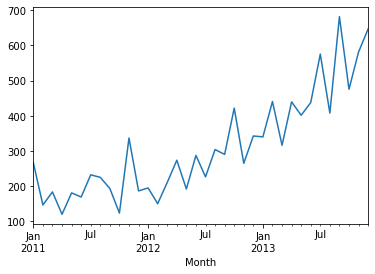

In [131]:
# load dataset
series = read_csv('sales-of-shampoo-over-a-three-ye.csv', engine='python', delimiter = ',', index_col=0, header=0, parse_dates=[0], skipfooter=2, squeeze=True, skip_blank_lines=True, date_parser=parser)
# skipfooter = 2 must be added so that the last two rows (an empty row and a footer row) will not be converted to 201y-mm, which also requires engine='python'
print(series.head())

# line plot
series.plot()
pyplot.show()


In [133]:
raw_values = series.values

In [135]:
print("Shape of dataset:", raw_values.shape)
print("5 samples of dataset:", raw_values[0:5])

Shape of dataset: (36,)
5 samples of dataset: [266.  145.9 183.1 119.3 180.3]


In [137]:
from pandas import Series

diff_values = difference(raw_values, interval=1)
print(diff_values[0:5])

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64


In [139]:
diff_values = diff(raw_values, interval=1)
print(diff_values[0:5])

[-120.1   37.2  -63.8   61.   -11.8]


In [141]:
inv_diff = inverse_diff(raw_values, diff_values, interval=1)
print(inv_diff[0:5])

[526.8 684.1 583.1 707.9 635.1]


In [143]:
from sklearn.preprocessing import MinMaxScaler

diff_values = diff_values.reshape(-1, 1)
print(diff_values.shape)
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(diff_values)

(35, 1)


In [145]:
lags = 1
supervised_dataframe = timeseries_to_supervised(data_scaled, lag=lags)

In [147]:
supervised_data = supervised_dataframe.values

In [149]:
train, test = dataset_split(supervised_data, train_ratio=0.67)

In [151]:
print(train.shape)


(23, 2)


In [153]:
units = 8
epochs = 100
model = fit_lstm(units, train, model_style='timestep', with_memory=False, epochs=epochs)

Epoch 1/100
23/23 - 1s - loss: 0.1439 - 1s/epoch - 57ms/step
Epoch 2/100
23/23 - 0s - loss: 0.1311 - 31ms/epoch - 1ms/step
Epoch 3/100
23/23 - 0s - loss: 0.1259 - 31ms/epoch - 1ms/step
Epoch 4/100
23/23 - 0s - loss: 0.1173 - 30ms/epoch - 1ms/step
Epoch 5/100
23/23 - 0s - loss: 0.1129 - 29ms/epoch - 1ms/step
Epoch 6/100
23/23 - 0s - loss: 0.1057 - 29ms/epoch - 1ms/step
Epoch 7/100
23/23 - 0s - loss: 0.1009 - 28ms/epoch - 1ms/step
Epoch 8/100
23/23 - 0s - loss: 0.0950 - 29ms/epoch - 1ms/step
Epoch 9/100
23/23 - 0s - loss: 0.0919 - 28ms/epoch - 1ms/step
Epoch 10/100
23/23 - 0s - loss: 0.0875 - 36ms/epoch - 2ms/step
Epoch 11/100
23/23 - 0s - loss: 0.0839 - 40ms/epoch - 2ms/step
Epoch 12/100
23/23 - 0s - loss: 0.0820 - 31ms/epoch - 1ms/step
Epoch 13/100
23/23 - 0s - loss: 0.0805 - 32ms/epoch - 1ms/step
Epoch 14/100
23/23 - 0s - loss: 0.0827 - 29ms/epoch - 1ms/step
Epoch 15/100
23/23 - 0s - loss: 0.0781 - 31ms/epoch - 1ms/step
Epoch 16/100
23/23 - 0s - loss: 0.0787 - 32ms/epoch - 1ms/step
Ep

In [155]:
model_ts_mem = fit_lstm(units, train, model_style='window', with_memory=True, epochs=epochs)

23/23 - 1s - loss: 0.1546 - 1s/epoch - 60ms/step
23/23 - 0s - loss: 0.1454 - 29ms/epoch - 1ms/step
23/23 - 0s - loss: 0.1395 - 29ms/epoch - 1ms/step
23/23 - 0s - loss: 0.1342 - 29ms/epoch - 1ms/step
23/23 - 0s - loss: 0.1290 - 35ms/epoch - 2ms/step
23/23 - 0s - loss: 0.1237 - 31ms/epoch - 1ms/step
23/23 - 0s - loss: 0.1182 - 28ms/epoch - 1ms/step
23/23 - 0s - loss: 0.1125 - 28ms/epoch - 1ms/step
23/23 - 0s - loss: 0.1067 - 29ms/epoch - 1ms/step
23/23 - 0s - loss: 0.1009 - 29ms/epoch - 1ms/step
23/23 - 0s - loss: 0.0951 - 28ms/epoch - 1ms/step
23/23 - 0s - loss: 0.0897 - 31ms/epoch - 1ms/step
23/23 - 0s - loss: 0.0847 - 29ms/epoch - 1ms/step
23/23 - 0s - loss: 0.0802 - 32ms/epoch - 1ms/step
23/23 - 0s - loss: 0.0765 - 32ms/epoch - 1ms/step
23/23 - 0s - loss: 0.0735 - 32ms/epoch - 1ms/step
23/23 - 0s - loss: 0.0712 - 32ms/epoch - 1ms/step
23/23 - 0s - loss: 0.0695 - 28ms/epoch - 1ms/step
23/23 - 0s - loss: 0.0683 - 28ms/epoch - 1ms/step
23/23 - 0s - loss: 0.0674 - 28ms/epoch - 1ms/step
2

In [157]:
# walk-forward validation on the test data
predictions = list()
expected_list = list()
for i in range(len(test)):
    # make one-step forecast

    data = test[i]
    data = data.reshape(1, len(data))    # turn 1D to 2D
    predicted_value = forecast_lstm(model, data, batch_size=1, model_style='timestep')
    
    #print("predicted_value:", predicted_value)
    # invert scaling
    predicted_value = data_inverse_scale(scaler, predicted_value)
    #print("inverse-scaled predicted value:", predicted_value[0, 0])
    
    # invert differencing
    predicted_values = inverse_diff(raw_values, predicted_value[0, 0], interval=len(test)+1-i)
    #print("inverse-diff predicted value: ", predicted_values)

    # store forecast
    predictions.append(predicted_values)
    expected = raw_values[len(train)+i]
    expected_list.append(expected)
    #print("expected:", expected)
    print('Month=%d, Predicted=%.2f, Expected=%.2f' % (i+1, predicted_values, expected))

1/1 [==============================] - 0s 427ms/step
Month=1, Predicted=298.86, Expected=342.30
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=356.22, Expected=339.70
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=377.57, Expected=440.40
1/1 [==============================] - 0s 18ms/step
Month=4, Predicted=396.03, Expected=315.90
1/1 [==============================] - 0s 14ms/step
Month=5, Predicted=356.39, Expected=439.30
1/1 [==============================] - 0s 16ms/step
Month=6, Predicted=439.76, Expected=401.30
1/1 [==============================] - 0s 19ms/step
Month=7, Predicted=426.75, Expected=437.40
1/1 [==============================] - 0s 17ms/step
Month=8, Predicted=479.18, Expected=575.50
1/1 [==============================] - 0s 16ms/step
Month=9, Predicted=502.62, Expected=407.60
1/1 [==============================] - 0s 16ms/step
Month=10, Predicted=452.33, Expected=682.00
1/1 [==============================] - 0s 21ms/s

In [159]:
# report performance
rmse = sqrt(mean_squared_error(expected_list, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 94.730


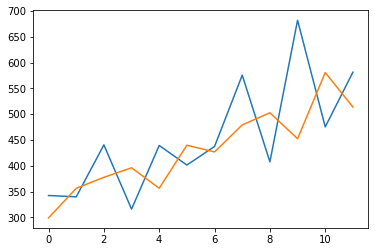

In [161]:
# line plot of observed vs predicted
pyplot.plot(expected_list)
pyplot.plot(predictions)
pyplot.show()